In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import edward as ed

In [4]:
import tensorflow as tf

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
from edward.models import Normal

In [8]:
plt.style.use('ggplot')

In [9]:
def build_toy_dataset(N=50, noise_std=0.1):
  x = np.linspace(-3, 3, num=N)
  y = np.cos(x) + np.random.normal(0, noise_std, size=N)
  x = x.astype(np.float32).reshape((N, 1))
  y = y.astype(np.float32)
  return x, y

In [10]:
def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.tanh(tf.matmul(x, W_0) + b_0)
  h = tf.matmul(h, W_1) + b_1
  return tf.reshape(h, [-1])

In [11]:
ed.set_seed(42)

N = 50  # number of data points
D = 1   # number of features

x_train, y_train = build_toy_dataset(N)

In [12]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

In [13]:

print(tf.get_default_graph())

In [14]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [15]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)]) # 10 is the times of sampling process

In [16]:
np.shape(inputs)
np.shape(x)
np.shape(mus)

TensorShape([Dimension(10), Dimension(400)])

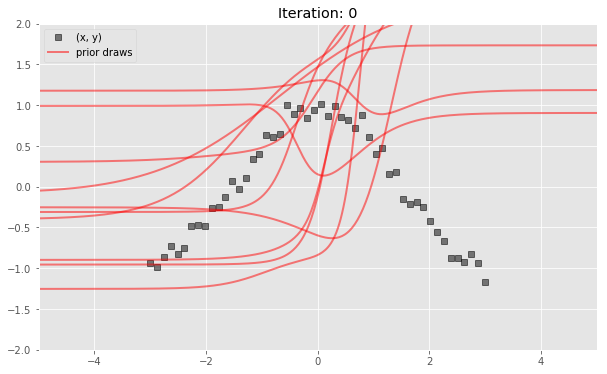

In [17]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [18]:
np.shape(outputs)
print(outputs[0].T)
np.shape(outputs[0].T)

[1.1773825  1.1773832  1.1773839  1.1773844  1.1773851  1.1773858
 1.1773865  1.1773874  1.1773882  1.1773891  1.17739    1.1773909
 1.177392   1.177393   1.1773942  1.1773953  1.1773965  1.177398
 1.1773992  1.1774006  1.177402   1.1774037  1.1774054  1.1774071
 1.1774089  1.1774108  1.1774129  1.177415   1.1774173  1.1774197
 1.177422   1.1774247  1.1774274  1.1774302  1.1774333  1.1774364
 1.1774398  1.1774433  1.1774468  1.1774507  1.1774548  1.1774591
 1.1774635  1.1774682  1.1774731  1.1774783  1.1774838  1.1774895
 1.1774955  1.1775019  1.1775086  1.1775154  1.1775229  1.1775304
 1.1775386  1.1775471  1.177556   1.1775653  1.1775752  1.1775856
 1.1775963  1.1776078  1.1776199  1.1776326  1.1776458  1.1776597
 1.1776744  1.17769    1.177706   1.1777229  1.1777408  1.1777596
 1.1777792  1.1777999  1.1778219  1.1778448  1.1778686  1.1778939
 1.1779206  1.1779482  1.1779776  1.1780083  1.1780405  1.1780745
 1.1781101  1.1781476  1.178187   1.1782285  1.178272   1.1783175
 1.1783655 

(400,)

In [20]:
#inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
#                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1})
inference.run(n_iter=1000, n_samples=50)

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.000


In [22]:
# If we do not use the 'data={y: y_train}', then the results are awful. This means that the inference actually used the network graph and the sample data to do approximation

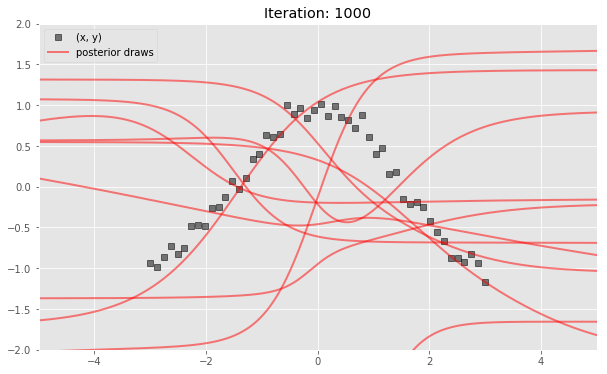

In [21]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()